In [53]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import joblib

In [54]:
df3 = pd.read_csv("citizen_requests_v2.csv")

In [55]:
df3['label'] = df3['label'].map({
    'жалоба_ЖКХ': 'жалоба_ЖКХ',
    'жалоба_благоустройство': 'жалоба_благоустройство',
    'жалоба_здравоохранение': 'жалоба_здравоохранение',
    'запрос_услуги_ЖКХ': 'запрос_ЖКХ',
    'запрос_услуги_благоустройство': 'запрос_благоустройство',
    'запрос_услуги_здравоохранение': 'запрос_здравоохранение',
    'предложение_ЖКХ': 'предложение_ЖКХ',
    'предложение_благоустройство': 'предложение_благоустройство',
    'предложение_здравоохранение': 'предложение_здравоохранение'
})

In [56]:
df1 = pd.read_csv("citizen_requests_refined.csv")
df2 = pd.read_csv("citizen_requests_extra2300.csv")
df = pd.concat([df1, df2, df3])
df = df.reset_index(drop=True)

In [57]:
texts = df["text"].astype(str).values
labels = df["label"].astype(str).values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
joblib.dump(label_encoder, "label_encoder.pkl")

X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.2, stratify=y
)

In [58]:
tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
joblib.dump(tokenizer, "tokenizer.pkl")

max_len = 121
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

In [59]:
model = Sequential([
    Embedding(20000, 128, input_length=max_len),
    LSTM(128, dropout=0.5, recurrent_dropout=0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y)), activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [60]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 67s 328ms/step - accuracy: 0.2768 - loss: 1.9546 - val_accuracy: 0.9914 - val_loss: 0.1571
Epoch 2/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 83s 334ms/step - accuracy: 0.9277 - loss: 0.2661 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 3/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 64s 337ms/step - accuracy: 0.9882 - loss: 0.0565 - val_accuracy: 1.0000 - val_loss: 3.0823e-04
Epoch 4/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 83s 345ms/step - accuracy: 0.9949 - loss: 0.0267 - val_accuracy: 1.0000 - val_loss: 5.0139e-05
Epoch 5/5
190/190 ━━━━━━━━━━━━━━━━━━━━ 82s 347ms/step - accuracy: 0.9943 - loss: 0.0298 - val_accuracy: 1.0000 - val_loss: 4.3423e-05


In [61]:
loss, acc = model.evaluate(X_test_seq, y_test)
print(f"✅ Accuracy: {acc:.3f}")

model.save("citizen_request_lstm.h5")


print("Модель и кодировщики успешно сохранены ✅")


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 1.0000 - loss: 4.4517e-05


✅ Accuracy: 1.000
Модель и кодировщики успешно сохранены ✅


60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step


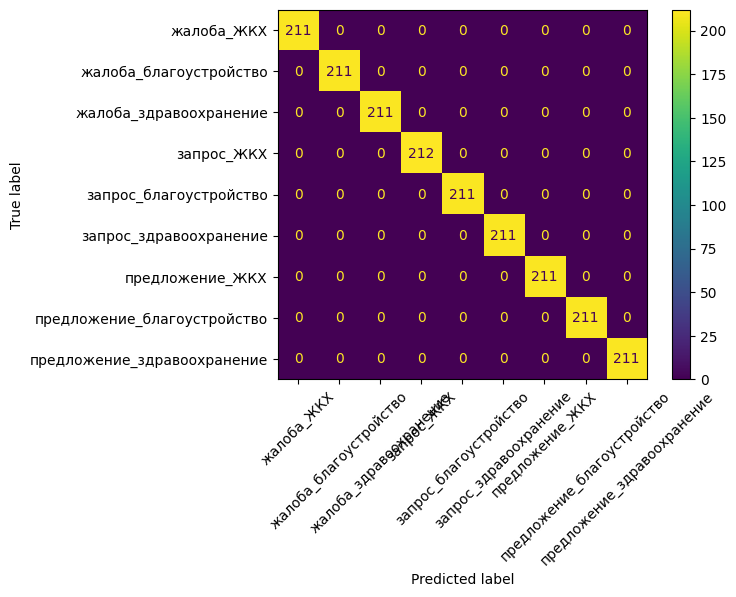

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(X_test_seq).argmax(axis=1)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_encoder.classes_, xticks_rotation=45)
plt.show()


In [63]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import joblib

# Загружаем модель и вспомогательные объекты
model = load_model("citizen_request_lstm.h5")
tokenizer = joblib.load("tokenizer.pkl")
label_encoder = joblib.load("label_encoder.pkl")

max_len = 100

def classify_text(text: str) -> str:
    seq = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=max_len)
    pred = model.predict(seq)
    label = label_encoder.inverse_transform([pred.argmax(axis=1)[0]])[0]
    return label


In [67]:
examples = [
    'Почему до сих пор не убрали снег с крыши нашего дома?',
    "Прошу установить скамейку во дворе дома.",
    "Как записаться к врачу в поликлинике?",
    "Предлагаю добавить урны возле школы.",
    "Сделайте ремонт в подъезде, штукатурка падает!",
    "В нашей больнице ужасные очереди.",
    "Не работает фонарь у остановки “Парк”."
]

for text in examples:
    print(f"{text}  →  {classify_text(text)}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Почему до сих пор не убрали снег с крыши нашего дома?  →  жалоба_благоустройство
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Прошу установить скамейку во дворе дома.  →  запрос_благоустройство
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Как записаться к врачу в поликлинике?  →  запрос_здравоохранение
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
Предлагаю добавить урны возле школы.  →  предложение_благоустройство
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Сделайте ремонт в подъезде, штукатурка падает!  →  запрос_благоустройство
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
В нашей больнице ужасные очереди.  →  жалоба_здравоохранение
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Не работает фонарь у остановки “Парк”.  →  жалоба_благоустройство
